In [1]:
try:
    from mumott.data_handling import DataContainer
except:
    !sh ../scripts/setup.sh
    !pip install --upgrade coverage pytest-cov

INFO:Setting the number of threads to 8. If your physical cores are fewer than this number, you may want to use numba.set_num_threads(n), and os.environ["OPENBLAS_NUM_THREADS"] = f"{n}" to set the number of threads to the number of physical cores n.
INFO:Setting numba log level to WARNING.


In [2]:
import sys
sys.path.insert(0, '/myhome/smartt')

import numpy as np
import matplotlib.pyplot as plt
import h5py
from pathlib import Path
from tqdm import tqdm
import copy

# Import mumott modules
from mumott.data_handling import DataContainer
from mumott.methods.basis_sets import SphericalHarmonics
from mumott.methods.projectors import SAXSProjector, SAXSProjectorCUDA
from mumott.methods.residual_calculators import GradientResidualCalculator
from mumott.optimization.loss_functions import SquaredLoss
from mumott.optimization.optimizers import LBFGS
from mumott.optimization.regularizers import Laplacian

# Import custom functions
from smartt.data_processing import _perform_reconstruction

%matplotlib inline

In [3]:
# Load saved results from HDF5
load_results = True  # Set to True to load
input_path = '/myhome/smartt/results/sparse_uncertainty_analysis.h5'

if load_results:
    print(f"Loading results from {input_path}...")
    
    with h5py.File(input_path, 'r') as f:
        # Load reconstructions
        all_reconstructions = f['all_reconstructions'][:]
        mean_reconstruction = f['mean_reconstruction'][:]
        std_reconstruction = f['std_reconstruction'][:]
        ground_truth = f['ground_truth'][:]
        
        # Load indices
        fixed_sparse_indices = f['fixed_sparse_indices'][:]
        subsample_indices_list = []
        for i in range(f.attrs['num_experiments']):
            subsample_indices = f[f'subsample_indices_{i}'][:]
            subsample_indices_list.append(subsample_indices)
        
        # Load metadata
        ell_max = f.attrs['ell_max']
        num_experiments = f.attrs['num_experiments']
        num_projections_sparse = f.attrs['num_projections_sparse']
        num_subsamples = f.attrs['num_subsamples']
        total_projections = f.attrs['total_projections']
        volume_shape = tuple(f.attrs['volume_shape'])
        num_coeffs = f.attrs['num_coeffs']
        seed = f.attrs['seed']
    
    print(f"Results loaded successfully!")
    print(f"\nLoaded data:")
    print(f"  all_reconstructions shape: {all_reconstructions.shape}")
    print(f"  mean_reconstruction shape: {mean_reconstruction.shape}")
    print(f"  std_reconstruction shape: {std_reconstruction.shape}")
    print(f"  ground_truth shape: {ground_truth.shape}")
    print(f"  Number of experiments: {num_experiments}")
    print(f"  Fixed sparse subset: {len(fixed_sparse_indices)} projections")
    print(f"  Subsample size: {num_subsamples} projections")
else:
    print("Results not loaded (set load_results=True to load)")

Loading results from /myhome/smartt/results/sparse_uncertainty_analysis.h5...
Results loaded successfully!

Loaded data:
  all_reconstructions shape: (5, 65, 82, 65, 45)
  mean_reconstruction shape: (65, 82, 65, 45)
  std_reconstruction shape: (65, 82, 65, 45)
  ground_truth shape: (65, 82, 65, 45)
  Number of experiments: 5
  Fixed sparse subset: 60 projections
  Subsample size: 48 projections


In [4]:
import torch
import lovely_tensors as lt
lt.monkey_patch()
volume = torch.from_numpy(mean_reconstruction)
volume


tensor[65, 82, 65, 45] n=15590250 (59Mb) x∈[-1.131e+03, 1.098e+03] μ=4.032 σ=28.131

In [5]:
from mumott.data_handling import DataContainer
from mumott import Geometry
import copy
from mumott.methods.projectors import SAXSProjector, SAXSProjectorCUDA
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib widget

In [6]:
#load data
dc = DataContainer('/myhome/data/smartt/shared/frogbone/dataset_qbin_0009.h5')
geometry = dc.geometry

INFO:Rotation matrices were loaded from the input file.


/opt/conda/lib/python3.10/site-packages/mumott/data_handling/data_container.py:228: DeprecationWarning: Entry name rotations is deprecated. Use inner_angle instead.
  _deprecated_key_warning('rotations')
/opt/conda/lib/python3.10/site-packages/mumott/data_handling/data_container.py:237: DeprecationWarning: Entry name tilts is deprecated. Use outer_angle instead.
  _deprecated_key_warning('tilts')
/opt/conda/lib/python3.10/site-packages/mumott/data_handling/data_container.py:247: DeprecationWarning: Entry name rot_mat is deprecated. Use rotation_matrix instead.
  _deprecated_key_warning('rot_mat')
/opt/conda/lib/python3.10/site-packages/mumott/data_handling/data_container.py:269: DeprecationWarning: Entry name offset_j is deprecated. Use j_offset instead.
  _deprecated_key_warning('offset_j')
/opt/conda/lib/python3.10/site-packages/mumott/data_handling/data_container.py:279: DeprecationWarning: Entry name offset_k is deprecated. Use k_offset instead.
  _deprecated_key_warning('offset_k'

INFO:Sample geometry loaded from file.
INFO:Detector geometry loaded from file.


## Test PyTorch ASTRA Projector with mumott Geometry

Now let's test the new PyTorch wrapper for ASTRA that works with mumott geometry.

In [7]:
# Import the new projector module
from smartt.projectors import forward_project, backproject, build_mumott_projector

print("Successfully imported smartt.projectors!")

Successfully imported smartt.projectors!


In [8]:
# Check what attributes the geometry object has
print("Geometry attributes:")
for attr in dir(geometry):
    if not attr.startswith('_'):
        print(f"  {attr}")

Geometry attributes:
  append
  delete_projections
  detector_angles
  detector_direction_origin
  detector_direction_positive_90
  full_circle_covered
  hash_inner_angles
  hash_inner_axes
  hash_j_offsets
  hash_k_offsets
  hash_outer_angles
  hash_outer_axes
  hash_rotations
  inner_angles
  inner_angles_as_array
  inner_axes
  inner_axes_as_array
  insert
  j_direction_0
  j_offsets
  j_offsets_as_array
  k_direction_0
  k_offsets
  k_offsets_as_array
  outer_angles
  outer_angles_as_array
  outer_axes
  outer_axes_as_array
  p_direction_0
  probed_coordinates
  projection_shape
  read
  reconstruction_rotations
  rotate_reconstruction
  rotate_system_vectors
  rotations
  rotations_as_array
  system_rotations
  two_theta
  volume_shape
  write


In [9]:
# Test computing basis vectors like SAXSProjector does
# Looking at the mumott projector code, the basis vectors are computed from the geometry
projector_test = SAXSProjector(geometry)
print("Checking projector attributes:")
print(f"  _basis_vector_projection shape: {projector_test._basis_vector_projection.shape}")
print(f"  _basis_vector_j shape: {projector_test._basis_vector_j.shape}")
print(f"  _basis_vector_k shape: {projector_test._basis_vector_k.shape}")

Checking projector attributes:
  _basis_vector_projection shape: (240, 3)
  _basis_vector_j shape: (240, 3)
  _basis_vector_k shape: (240, 3)


In [10]:
from mumott.core.probed_coordinates import ProbedCoordinates
[x.shape for x in geometry.probed_coordinates.to_spherical]
torch.tensor(geometry.probed_coordinates.to_spherical[1])

tensor[240, 8, 3] f64 n=5760 (45Kb) x∈[0.009, 3.142] μ=1.675 σ=0.610

In [11]:
projector = SAXSProjector(geometry)
basis_set = SphericalHarmonics(ell_max=8, probed_coordinates=geometry.probed_coordinates) 
forward_projections = projector.forward(volume.numpy().astype(np.float64))
slice_projection_mumott = basis_set.forward(forward_projections)
forward_projections.shape, slice_projection_mumott.shape

((240, 73, 100, 45), (240, 73, 100, 8))

In [12]:
# Reload the module to get the updated code
import importlib
import smartt.projectors.astra_projector
importlib.reload(smartt.projectors.astra_projector)
from smartt.projectors import forward_project, backproject, build_mumott_projector
print("Module reloaded successfully!")

Module reloaded successfully!


In [13]:
# Restart kernel and reimport to clear all caches
import sys
# Remove from cache
if 'smartt.projectors.astra_projector' in sys.modules:
    del sys.modules['smartt.projectors.astra_projector']
if 'smartt.projectors' in sys.modules:
    del sys.modules['smartt.projectors']

# Now import fresh
from smartt.projectors import forward_project, backproject, build_mumott_projector
print("Fresh import successful!")

Fresh import successful!


In [14]:
# Test forward projection with a single channel of the volume
# Extract one channel from the volume for testing
test_volume = volume
print(f"Test volume shape: {test_volume.shape}")
print(f"Geometry volume shape: {geometry.volume_shape}")
print(f"Geometry projection shape: {geometry.projection_shape}")
print(f"Number of projections: {len(geometry)}")

Test volume shape: torch.Size([65, 82, 65, 45])
Geometry volume shape: [65 82 65]
Geometry projection shape: [ 73 100]
Number of projections: 240


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Perform forward projection using the PyTorch wrapper
projections_torch = forward_project(volume.to(device), geometry, device=device).cpu()
print(f"Projections shape: {projections_torch.shape}")
print(f"Projections dtype: {projections_torch.dtype}")
print(f"Projections device: {projections_torch.device}")
print(f"Projections stats: min={projections_torch.min().item():.3f}, max={projections_torch.max().item():.3f}, mean={projections_torch.mean().item():.3f}")

Projections shape: torch.Size([240, 73, 100, 45])
Projections dtype: torch.float32
Projections device: cpu
Projections stats: min=-31125.123, max=28184.654, mean=188.673


In [16]:
projections_mumott = torch.from_numpy(forward_projections)
projections_mumott, projections_torch

(tensor[240, 73, 100, 45] f64 n=78840000 (0.6Gb) x∈[-3.112e+04, 2.818e+04] μ=189.101 σ=1.113e+03,
 tensor[240, 73, 100, 45] n=78840000 (0.3Gb) x∈[-3.113e+04, 2.818e+04] μ=188.673 σ=1.113e+03)

In [17]:
# Statistical Analysis: Compare mumott vs PyTorch ASTRA projections
print("=" * 80)
print("STATISTICAL COMPARISON: mumott SAXSProjector vs PyTorch ASTRA Projector")
print("=" * 80)

# Convert to numpy for easier analysis
proj_mumott_np = projections_mumott.cpu().numpy()
proj_torch_np = projections_torch.cpu().numpy()

print(f"\nShape comparison:")
print(f"  mumott:  {proj_mumott_np.shape}")
print(f"  PyTorch: {proj_torch_np.shape}")

print(f"\nBasic Statistics:")
print(f"  {'Metric':<20} {'mumott':<20} {'PyTorch ASTRA':<20} {'Difference':<20}")
print(f"  {'-'*20} {'-'*20} {'-'*20} {'-'*20}")
print(f"  {'Min':<20} {proj_mumott_np.min():<20.6f} {proj_torch_np.min():<20.6f} {proj_torch_np.min() - proj_mumott_np.min():<20.6f}")
print(f"  {'Max':<20} {proj_mumott_np.max():<20.6f} {proj_torch_np.max():<20.6f} {proj_torch_np.max() - proj_mumott_np.max():<20.6f}")
print(f"  {'Mean':<20} {proj_mumott_np.mean():<20.6f} {proj_torch_np.mean():<20.6f} {proj_torch_np.mean() - proj_mumott_np.mean():<20.6f}")
print(f"  {'Std':<20} {proj_mumott_np.std():<20.6f} {proj_torch_np.std():<20.6f} {proj_torch_np.std() - proj_mumott_np.std():<20.6f}")
print(f"  {'Median':<20} {np.median(proj_mumott_np):<20.6f} {np.median(proj_torch_np):<20.6f} {np.median(proj_torch_np) - np.median(proj_mumott_np):<20.6f}")

# Compute error metrics
abs_diff = np.abs(proj_mumott_np - proj_torch_np)
rel_diff = abs_diff / (np.abs(proj_mumott_np) + 1e-10)  # Avoid division by zero
mse = np.mean((proj_mumott_np - proj_torch_np) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(abs_diff)
max_abs_error = np.max(abs_diff)

print(f"\nError Metrics:")
print(f"  {'MSE (Mean Squared Error)':<30}: {mse:.6e}")
print(f"  {'RMSE (Root MSE)':<30}: {rmse:.6e}")
print(f"  {'MAE (Mean Absolute Error)':<30}: {mae:.6e}")
print(f"  {'Max Absolute Error':<30}: {max_abs_error:.6e}")
print(f"  {'Mean Relative Error':<30}: {rel_diff.mean():.6%}")
print(f"  {'Max Relative Error':<30}: {rel_diff.max():.6%}")

# Correlation analysis
correlation = np.corrcoef(proj_mumott_np.flatten(), proj_torch_np.flatten())[0, 1]
print(f"\nCorrelation Analysis:")
print(f"  {'Pearson Correlation':<30}: {correlation:.10f}")
print(f"  {'R² (Coefficient of Determination)':<30}: {correlation**2:.10f}")

# Signal-to-Noise Ratio (SNR) style metric
signal_power = np.mean(proj_mumott_np ** 2)
noise_power = np.mean((proj_mumott_np - proj_torch_np) ** 2)
snr_db = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('inf')
print(f"  {'SNR (Signal-to-Noise Ratio)':<30}: {snr_db:.2f} dB")

# Percentile-based error analysis
print(f"\nPercentile-based Absolute Error Analysis:")
percentiles = [50, 75, 90, 95, 99, 99.9]
for p in percentiles:
    val = np.percentile(abs_diff, p)
    print(f"  {p}th percentile: {val:.6e}")

print("=" * 80)

STATISTICAL COMPARISON: mumott SAXSProjector vs PyTorch ASTRA Projector

Shape comparison:
  mumott:  (240, 73, 100, 45)
  PyTorch: (240, 73, 100, 45)

Basic Statistics:
  Metric               mumott               PyTorch ASTRA        Difference          
  -------------------- -------------------- -------------------- --------------------
  Min                  -31123.523897        -31125.123047        -1.599150           
  Max                  28183.448788         28184.654297         1.205509            
  Mean                 189.100745           188.672501           -0.428244           
  Std                  1112.624147          1112.872437          0.248289            
  Median               0.000000             0.000000             -0.000000           

Error Metrics:
  MSE (Mean Squared Error)      : 1.067268e+03
  RMSE (Root MSE)               : 3.266907e+01
  MAE (Mean Absolute Error)     : 4.117262e+00
  Max Absolute Error            : 4.887822e+03
  Mean Relative Error   

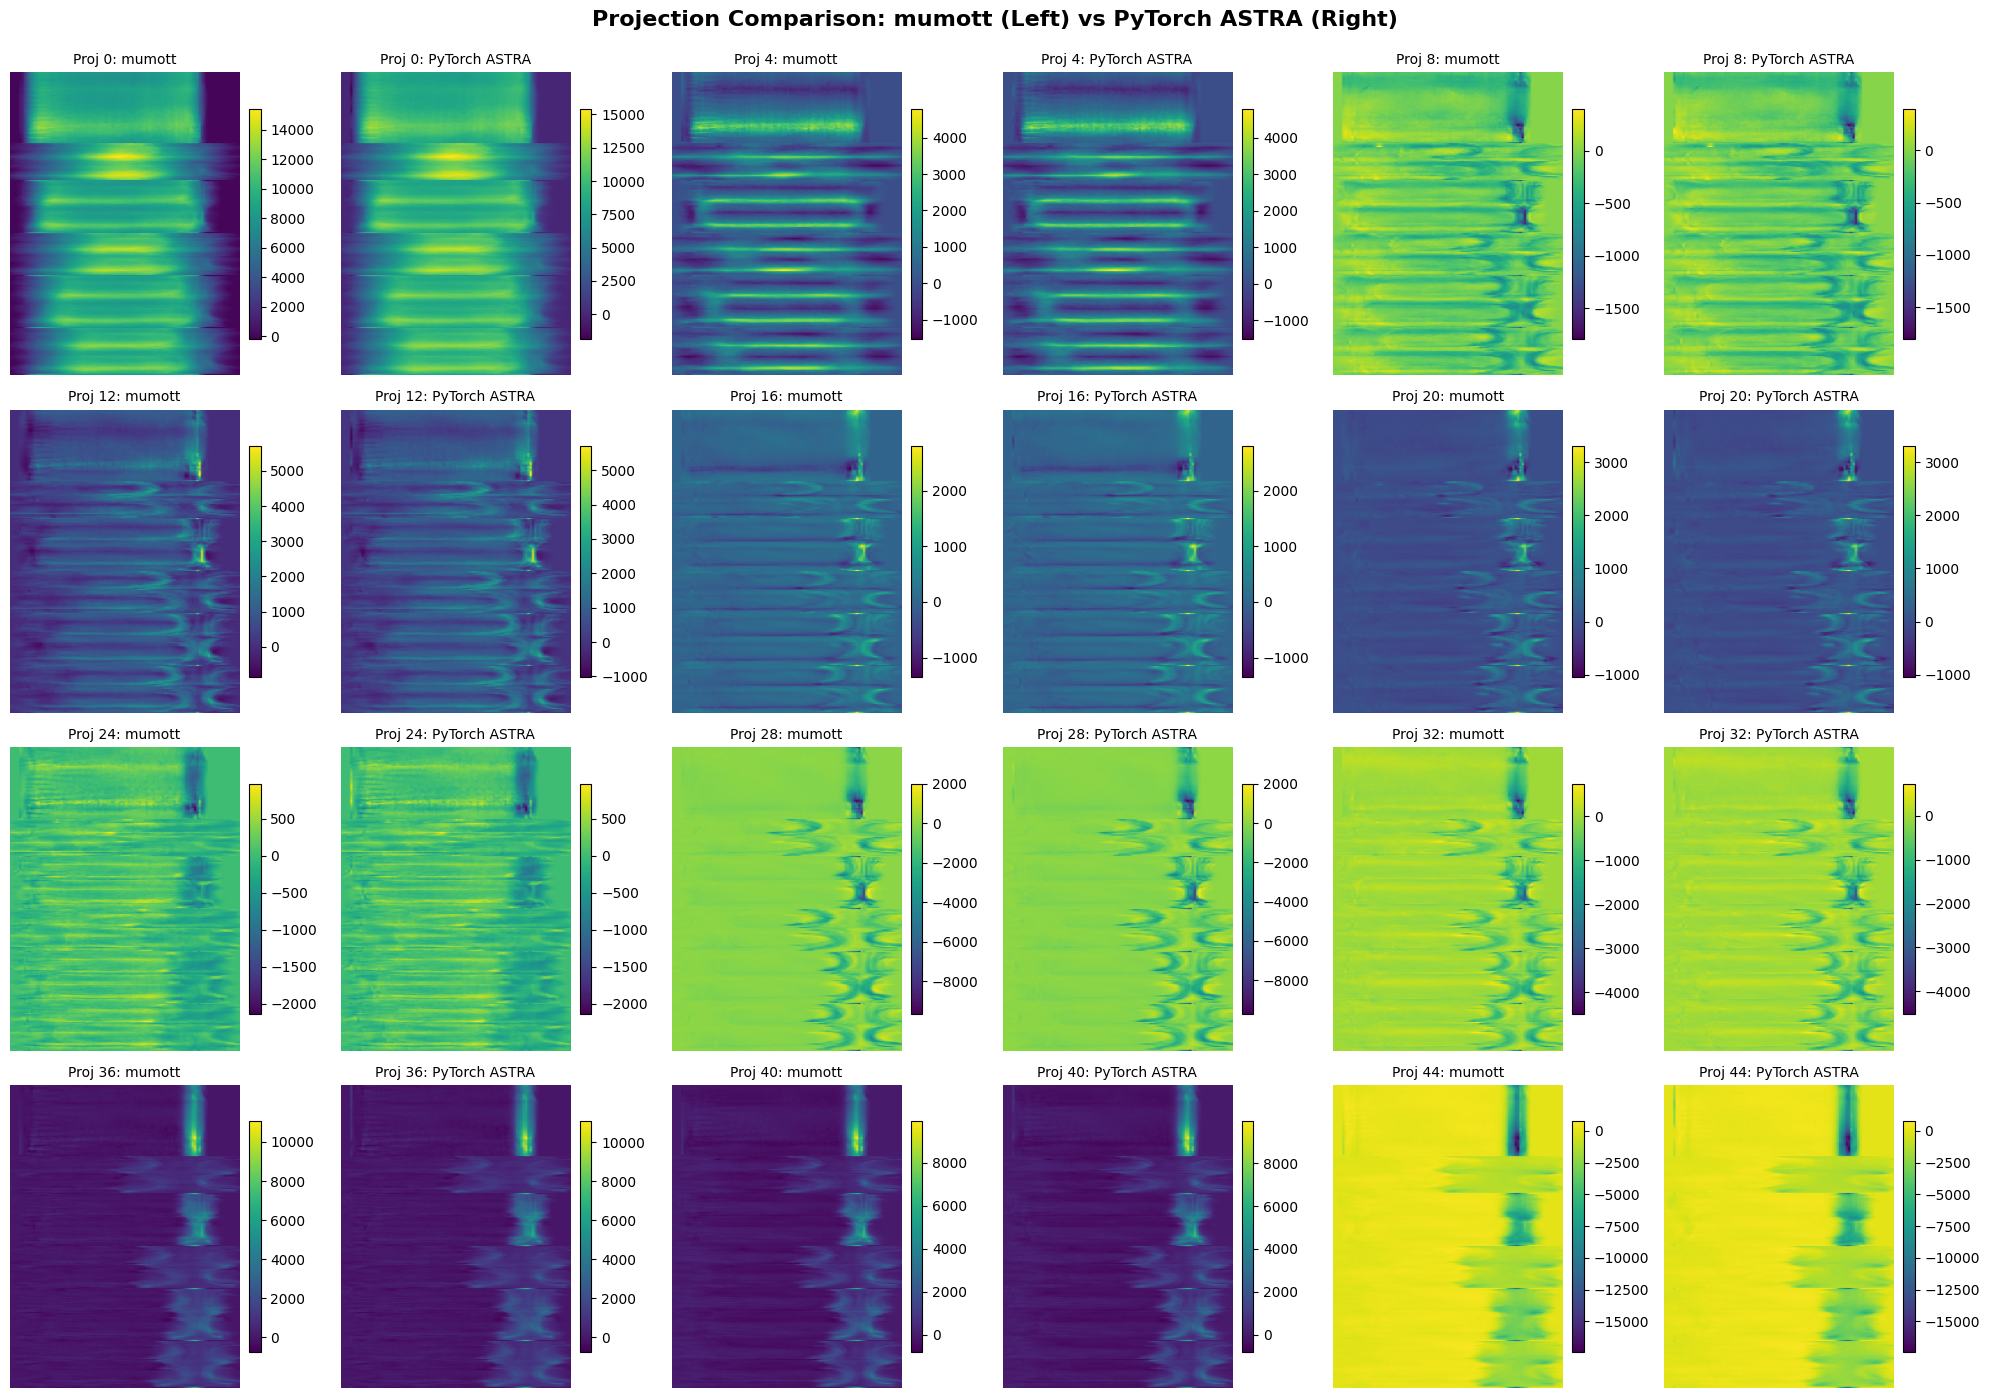

In [18]:
# Qualitative Visualization Analysis - Part 1: Side-by-side Projections
fig, axes = plt.subplots(4, 6, figsize=(20, 14))
fig.suptitle('Projection Comparison: mumott (Left) vs PyTorch ASTRA (Right)', 
             fontsize=16, fontweight='bold', y=0.995)

# Select 12 evenly spaced projections
n_projs = proj_mumott_np.shape[-1]
slice_idx = 40
proj_indices = np.linspace(0, n_projs-1, 12, dtype=int)

for idx, proj_idx in enumerate(proj_indices):
    row = idx // 3
    col_pair = (idx % 3) * 2
    
    # mumott projection
    ax_mumott = axes[row, col_pair]
    im1 = ax_mumott.imshow(proj_mumott_np[:, slice_idx, :, proj_idx], cmap='viridis', aspect='auto')
    ax_mumott.set_title(f'Proj {proj_idx}: mumott', fontsize=10)
    ax_mumott.axis('off')
    plt.colorbar(im1, ax=ax_mumott, fraction=0.046, pad=0.04)
    
    # PyTorch ASTRA projection
    ax_torch = axes[row, col_pair + 1]
    im2 = ax_torch.imshow(proj_torch_np[:, slice_idx, :, proj_idx], cmap='viridis', aspect='auto')
    ax_torch.set_title(f'Proj {proj_idx}: PyTorch ASTRA', fontsize=10)
    ax_torch.axis('off')
    plt.colorbar(im2, ax=ax_torch, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [19]:
projections_torch

tensor[240, 73, 100, 45] n=78840000 (0.3Gb) x∈[-3.113e+04, 2.818e+04] μ=188.673 σ=1.113e+03

# Evaluate spherical harmonics

In [20]:
basis_set = SphericalHarmonics(ell_max=8, probed_coordinates=geometry.probed_coordinates) 
slice_projection_mumott = basis_set.forward(forward_projections)
torch.tensor(slice_projection_mumott)

tensor[240, 73, 100, 8] f64 n=14016000 (0.1Gb) x∈[-3.961e+04, 4.656e+05] μ=4.555e+03 σ=5.860e+03

In [25]:
pytorch_projector = build_mumott_projector(geometry, device=device)
projection_matrix = torch.tensor(
    basis_set.projection_matrix.astype(np.float32),
    device=device, dtype=torch.float32
)

tensor[240, 73, 100, 8] n=14016000 (53Mb) x∈[-4.446e+04, 4.695e+05] μ=4.547e+03 σ=5.891e+03 tensor[240, 73, 100, 8] f64 n=14016000 (0.1Gb) x∈[-3.961e+04, 4.656e+05] μ=4.555e+03 σ=5.860e+03


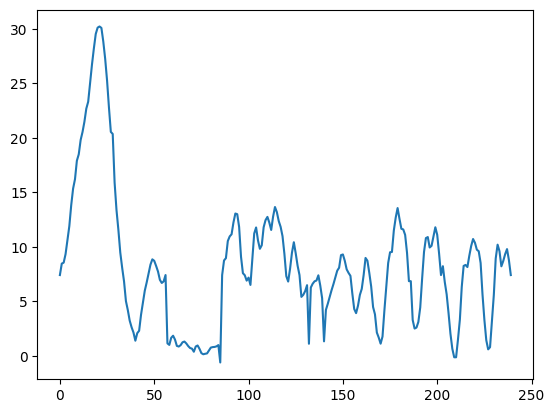

tensor[240] f64 1.9Kb x∈[-0.592, 30.216] μ=8.294 σ=6.293

In [30]:
from smartt.shutils.evaulate_sh import forward_quadrature
pred_values = forward_quadrature(
    geometry.probed_coordinates, 
    # torch.tensor(forward_projections), 
    projections_torch,
    # projection_matrix=projection_matrix,  # Use mumott's projection_matrix for exact matching
    ell_max=ell_max, mode='simpson'
)

print(pred_values, torch.tensor(slice_projection_mumott))
diffs  = (torch.tensor(slice_projection_mumott)  - pred_values)
diffs = diffs.reshape(diffs.shape[0], -1).mean(dim=1)
plt.plot(diffs)
plt.show()
diffs


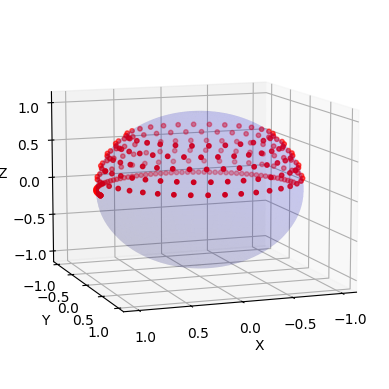

In [24]:
#plot original projections
rotation_angles_rad = dc.geometry.inner_angles[:]
tilt_angles_rad = list(np.pi/2-np.array(dc.geometry.outer_angles))[:]

r = 1
x = r * np.sin(tilt_angles_rad) * np.cos(rotation_angles_rad)
y = r * np.sin(tilt_angles_rad) * np.sin(rotation_angles_rad)
z = r * np.cos(tilt_angles_rad)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
X = r * np.outer(np.cos(u), np.sin(v))
Y = r * np.outer(np.sin(u), np.sin(v))
Z = r * np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(X, Y, Z, color='b', alpha=0.1)  
ax.scatter(x, y, z, color=['r' if abs(x) < 1e-5 else 'b' for x in diffs], s=10)  
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=10, azim=70)
plt.show()